In [1]:
import numpy as np

In [2]:
import  keras.backend as K

Using TensorFlow backend.


In [3]:
import tensorflow as tf

In [80]:
a = [1,2,3,1,2,4,6,6,6,6]
b = [3,1,2,3,3,1,6,6,6,6] # 真实标签不能有blank
c = [2,1,0,2,3,4,6,6,6,6]
y_true = np.stack([a,b,c]).astype(np.float32)

In [81]:
y_pred = np.random.rand(3,20,6).astype(np.float32) # 实际上字母表只能有5

input_length = K.stack([[7],[7],[7]])
# input_length = tf.to_int32(tf.squeeze(input_length, axis=-1))

label_length = K.stack([[6],[6],[5]])
# label_length = tf.to_int32(tf.squeeze(label_length, axis=-1))


In [82]:
result = K.ctc_batch_cost(y_true,y_pred,input_length,label_length)
K.eval(result)

array([[ 8.3892765],
       [13.023777 ],
       [ 9.0743685]], dtype=float32)

预处理长度标签

Instructions for updating:
Use tf.cast instead.


In [41]:
y_pred = K.random_uniform((3,20,3),dtype = tf.float32)
input_length = K.stack([[16],[16],[16]])
input_length = tf.to_int32(tf.squeeze(input_length, axis=-1))

y_pred = K.softmax(y_pred)

npy = K.eval(y_pred)

argres = K.argmax(y_pred)
print(K.eval(argres))

res = K.ctc_decode(y_pred,input_length,True)
# print(res[0][0])
print(K.get_value(res[0][0]))

[[2 0 1 1 1 0 1 2 2 0 1 2 2 2 2 0 0 2 1 0]
 [0 0 2 0 0 1 1 0 0 1 1 2 0 0 2 0 2 1 2 2]
 [2 1 2 0 1 2 1 1 0 0 0 2 0 0 2 1 1 1 0 0]]
[[ 0  1  0  1  0  0  0  1]
 [ 0  1  1  1  0  1 -1 -1]
 [ 0  1  1  1  0  1  1 -1]]


In [24]:
from matplotlib import pyplot as plt

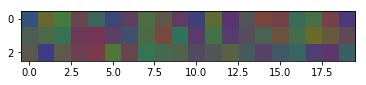

In [28]:
plt.imshow(npy)

In [29]:
npy

array([[[0.20023355, 0.32307166, 0.4766948 ],
        [0.4011294 , 0.40913573, 0.18973489],
        [0.2731297 , 0.48647198, 0.24039835],
        [0.40608773, 0.28076187, 0.31315044],
        [0.24268793, 0.3918834 , 0.36542872],
        [0.23296367, 0.28131068, 0.4857257 ],
        [0.37305185, 0.25081688, 0.3761313 ],
        [0.29544595, 0.4389235 , 0.26563054],
        [0.37625974, 0.34488413, 0.27885607],
        [0.38269362, 0.23268273, 0.38462374],
        [0.2532506 , 0.25779969, 0.48894972],
        [0.3584399 , 0.43123007, 0.21032996],
        [0.35479924, 0.20467289, 0.4405279 ],
        [0.32194534, 0.33220798, 0.34584668],
        [0.48599094, 0.27127713, 0.24273199],
        [0.4510872 , 0.2620922 , 0.28682062],
        [0.22533661, 0.42409223, 0.35057113],
        [0.28591192, 0.4417597 , 0.27232832],
        [0.46001107, 0.25427112, 0.28571782],
        [0.2979188 , 0.22493517, 0.47714597]],

       [[0.3019895 , 0.36636353, 0.33164695],
        [0.29811713, 0.4118163 ,

In [8]:
label_length,input_length

(<tf.Tensor: id=1, shape=(3,), dtype=int32, numpy=array([6, 6, 6])>,
 <tf.Tensor: id=3, shape=(3,), dtype=int32, numpy=array([4, 3, 5])>)

执行 ctc_label_dense_to_sparse(y_true, label_length)，转到相应的方法


y_true 的别名为 labels

In [9]:
labels = y_true
label_lengths =  label_length

label_shape = tf.shape(labels)
num_batches_tns = tf.stack([label_shape[0]])
max_num_labels_tns = tf.stack([label_shape[1]])

In [10]:
def range_less_than(_, current_input):
    return tf.expand_dims(tf.range(label_shape[1]), 0) < tf.fill(
        max_num_labels_tns, current_input)

def concatenate(tensors, axis=-1):
    """Concatenates a list of tensors alongside the specified axis.

    # Arguments
        tensors: list of tensors to concatenate.
        axis: concatenation axis.

    # Returns
        A tensor.
    """
    if axis < 0:
        rank = ndim(tensors[0])
        if rank:
            axis %= rank
        else:
            axis = 0

    if all([isinstance(x, tf.SparseTensor) for x in tensors]):
        return tf.sparse_concat(axis, tensors)
    else:
        return tf.concat([K.to_dense(x) for x in tensors], axis)

In [11]:
from tensorflow.python.ops import functional_ops

init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
dense_mask = functional_ops.scan(range_less_than, label_lengths,
                                 initializer=init, parallel_iterations=1)
dense_mask = dense_mask[:, 0, :]

label_array = tf.reshape(tf.tile(tf.range(label_shape[1]), num_batches_tns),
                         label_shape)
label_ind = tf.boolean_mask(label_array, dense_mask)

batch_array = tf.transpose(tf.reshape(tf.tile(tf.range(label_shape[0]),
                                              max_num_labels_tns), tf.reverse(label_shape, [0]))) # 这里，tf方法接收的是一维向量，而keras接收的是一个int
batch_ind = tf.boolean_mask(batch_array, dense_mask)
indices = tf.transpose(tf.reshape(concatenate([batch_ind, label_ind], axis=0), [2, -1]))

vals_sparse = tf.gather_nd(labels, indices)

In [12]:
sparse_labels = tf.to_int32(tf.SparseTensor(tf.to_int64(indices), vals_sparse, tf.to_int64(label_shape)))

Instructions for updating:
Use tf.cast instead.


In [13]:
sparse_labels.values

<tf.Tensor: id=194, shape=(18,), dtype=int32, numpy=array([1, 2, 3, 1, 2, 4, 3, 1, 2, 3, 5, 1, 2, 1, 0, 2, 3, 4])>

In [14]:
y_pred = tf.log(tf.transpose(y_pred, perm=[1, 0, 2]) + 1e-7)

# 真正计算CTC-loss

In [21]:
preprocess_collapse_repeated=False
ctc_merge_repeated=True
ignore_longer_outputs_than_inputs=False
